In [1]:
%matplotlib inline
import sys
sys.path.append("../core")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.image as mpimg
import pickle
import time
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection

tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow.python.client import device_lib
# possibly need to uninstall and reinstall tensorflow 
#device_lib.list_local_devices() #only recognizes M4000

In [53]:

    
def ref_sample(N):
    R = tf.random.normal([N,2],mean=0.0,stddev=1.0)
    return R

def moon_sample(N):
    noisy_moons = datasets.make_moons(n_samples=N, noise=.05)
    X, y = noisy_moons
    X = tf.constant(StandardScaler().fit_transform(X),dtype=tf.float32)
    return X

def gridTransform(gridMap,N_lines=20,N_pts=500,xlims=(-8.0,8.0),ylims=(-8.0,8.0)):
    h_lines = []
    v_lines = []
    xa,xb = xlims
    ya,yb = ylims
    x_vals = np.linspace(xa,xb,N_lines)
    y_vals = np.linspace(ya,yb,N_lines)
    x = np.reshape(np.linspace(xa,xb,N_pts),(N_pts,1))
    y = np.reshape(np.linspace(xa,xb,N_pts),(N_pts,1))

    for i in range(N_lines):
        h_lines.append(np.concatenate((x,y_vals[i]*np.ones((N_pts,1))),axis=-1))
        v_lines.append(np.concatenate((x_vals[i]*np.ones((N_pts,1)),y),axis=-1))

    h_lines_new = []
    v_lines_new = []
    for i in range(N_lines):
        H,V = tf.cast(h_lines[i],tf.float32),tf.cast(v_lines[i],tf.float32)
        H_out = gridMap(H)
        V_out = gridMap(V)
        h_lines_new.append(H_out)
        v_lines_new.append(V_out)
    original_lines = [h_lines,v_lines]   
    new_lines = [h_lines_new,v_lines_new]
    return original_lines,new_lines

# clean up code to just use Keras.model
def gridTransformPlot(mapForward,mapInverse,title,filename,
                      X_sample=None,Z_sample=ref_sample,
                      Ns=500,alpha=0.5,lw_grid=2.0,
                      N_lines1=20,N_lines2=20,
                      constraint_index1 = [5,10],
                      constraint_index2 = [5,10],
                      xlims1=(-2.0,2.0),
                      ylims1=(-2.0,2.0),
                      xlims2=(-2.0,2.0),
                      ylims2=(-2.0,2.0)):
    
    x_inf,z_inf = gridTransform(mapInverse,N_lines=N_lines1,xlims=xlims1,ylims=ylims1)
    z_gen,x_gen = gridTransform(mapForward,N_lines=N_lines2,xlims=xlims2,ylims=ylims2)
    
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    
    #c1 = 'k'
    #c2 = 'red'
    c1,c2 = 'k','k'
    color_constraint = ['purple','r']
    lw_constraint = '3.0'
    for i in range(N_lines1):
        if i == constraint_index1[0]:
            c1 = color_constraint[0]
            lw = lw_constraint
        elif i == constraint_index1[1]:
            c1 = color_constraint[1]
            lw = lw_constraint
        else:
            c1 = 'k'
            lw=lw_grid
        
        ax[0,0].plot(x_inf[0][i][:,0],x_inf[0][i][:,1],c=c1,alpha=alpha,lw=lw)
        ax[0,0].plot(x_inf[1][i][:,0],x_inf[1][i][:,1],c=c2,alpha=alpha,lw=lw_grid)

        ax[0,1].plot(z_inf[0][i][:,0],z_inf[0][i][:,1],c=c1,alpha=alpha,lw=lw)
        ax[0,1].plot(z_inf[1][i][:,0],z_inf[1][i][:,1],c=c2,alpha=alpha,lw=lw_grid)
        
    for i in range(N_lines2):
        if i == constraint_index2[0]:
            c1 = color_constraint[0]
            lw = lw_constraint
        elif i == constraint_index2[1]:
            c1 = color_constraint[1]
            lw = lw_constraint
        else:
            c1 = 'k'
            lw=lw_grid
        
        ax[1,0].plot(x_gen[0][i][:,0],x_gen[0][i][:,1],c=c1,alpha=alpha,lw=lw)
        ax[1,0].plot(x_gen[1][i][:,0],x_gen[1][i][:,1],c=c2,alpha=alpha,lw=lw_grid)

        ax[1,1].plot(z_gen[0][i][:,0],z_gen[0][i][:,1],c=c1,alpha=alpha,lw=lw)
        ax[1,1].plot(z_gen[1][i][:,0],z_gen[1][i][:,1],c=c2,alpha=alpha,lw=lw_grid)

    
    X_inf = X_sample(Ns)
    Z_inf = mapInverse(X_inf)
    
    Z_gen = Z_sample(Ns)
    X_gen = mapForward(Z_gen)
    
    ax[0,0].scatter(X_inf[:,0],X_inf[:,1],alpha=0.4,c='lightblue')
    ax[0,1].scatter(Z_inf[:,0],Z_inf[:,1],alpha=0.4,c='lightblue')
    
    ax[1,0].scatter(X_gen[:,0],X_gen[:,1],alpha=0.4,c='lightgreen')
    ax[1,1].scatter(Z_gen[:,0],Z_gen[:,1],alpha=0.4,c='lightgreen')
    
    ax[0,0].set(xlim=(-4,4),ylim=(-1,4))
    ax[1,0].set(xlim=(-4,4),ylim=(-1,4))
    
    ax[0,1].set(xlim=(-4,4),ylim=(-4,4))
    ax[1,1].set(xlim=(-4,4),ylim=(-4,4))
    
    ax[0,0].set_aspect('auto')
    ax[1,0].set_aspect('auto')
    ax[0,1].set_aspect('auto')
    ax[1,1].set_aspect('auto')
    
    ax[0,0].set_title('Data Space $X$',pad=20)
    ax[0,1].set_title('Latent Space $Z$',pad=20)
    fig.subplots_adjust(wspace=0.4)
    fig.text(0.50,0.70,r'$\mathcal{\Rightarrow}$',fontsize=32,horizontalalignment='center')
    fig.text(0.50,0.30,r'$\mathcal{\Leftarrow}$',fontsize=32,horizontalalignment='center')
    fig.suptitle(title)
    plt.savefig(filename,dpi=200)

In [54]:
# Banana True Map
params = (2.0,1.0,0.2,0.0) #(a1,a2,a3,theta)
bMap = bananaMap(params)
bFlow = tfd.TransformedDistribution(
                        distribution=tfd.MultivariateNormalDiag(loc=tf.zeros([2],tf.float32)),
                        bijector=bMap)
# Banana NVP Map
lr = 1e-4
beta_1 = 0.9
beta_2 = 0.999
N = 5000
batch_size = 100
maxIts = 200
loss = -999

nvp = NVP(num_bijectors=2,neuron_list=[100,100])
opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, epsilon=1e-08)
XT = bFlow.sample(N) # target
R = ref_sample(N)
# have to do forward pass before training model to initialize it 
_ = nvp(R)

@tf.function
def KL_train_nvp(model,x_target,opt): 
    with tf.GradientTape() as tape:
        tape.watch(x_target)
        loss = -tf.reduce_mean(model.flow.log_prob(x_target)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    del tape
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

In [58]:
# Initializing nvp for noise moon dataset
# Adam optimizer parameters
lr = 1e-4
beta_1 = 0.9
beta_2 = 0.999
#Number of Target Samples
N = 5000
#Batch Size
batch_size = 100
#Num of Epochs 
maxIts = 400
loss = -999
# sampling function
# take in dimensionality of latent space and number of data points
opt = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, epsilon=1e-08)
nvp = NVP(num_bijectors=4,neuron_list=[200,200])
R = ref_sample(N)
_ = nvp(R)
XT = moon_sample(N)

@tf.function
def KL_train_nvp(model,x_target,opt): 
    with tf.GradientTape() as tape:
        tape.watch(x_target)
        loss = -tf.reduce_mean(model.flow.log_prob(x_target)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    del tape
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

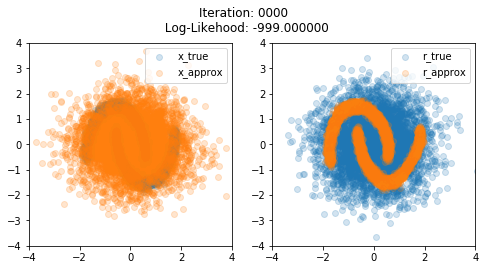

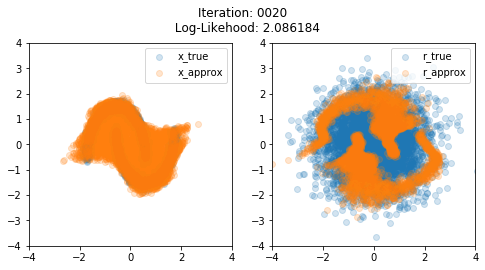

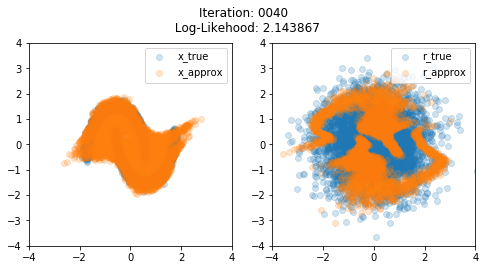

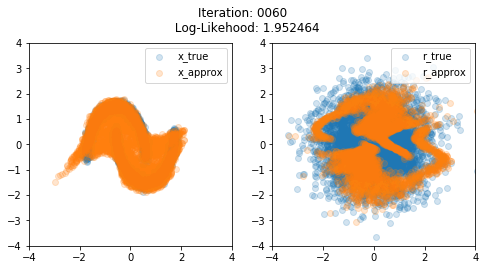

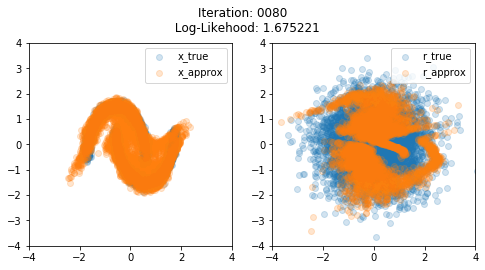

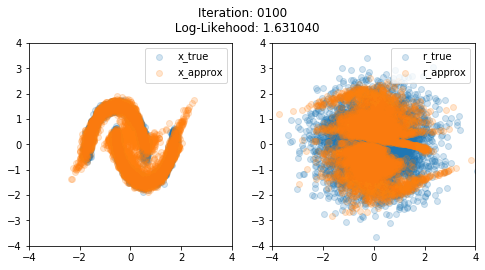

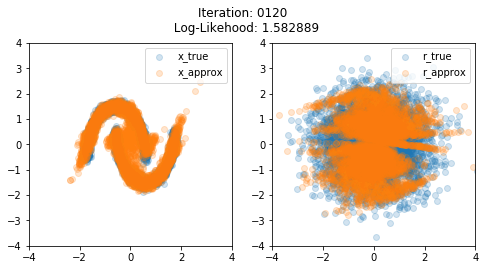

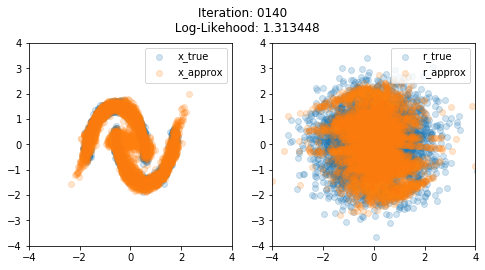

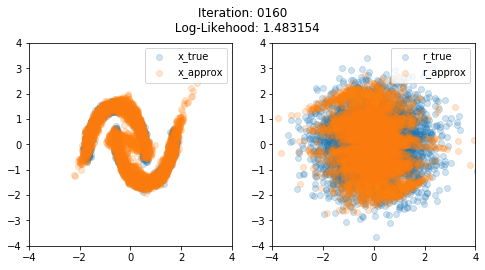

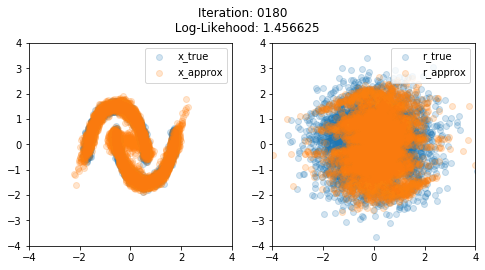

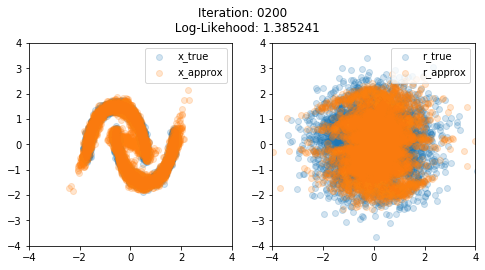

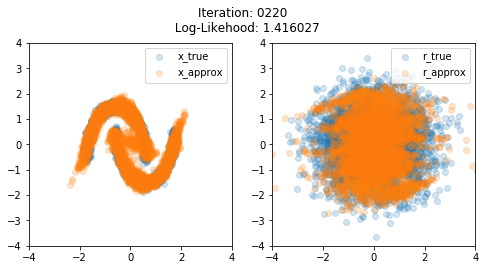

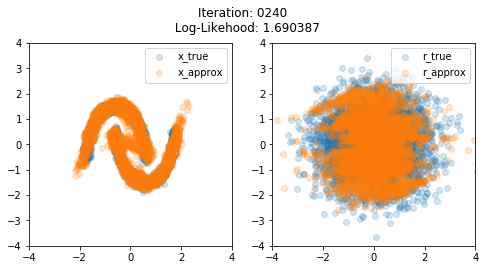

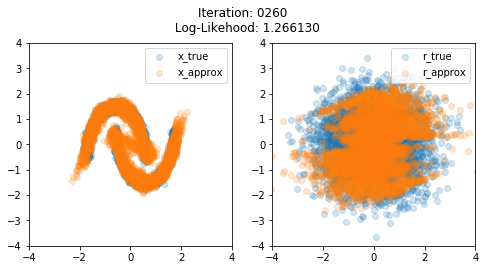

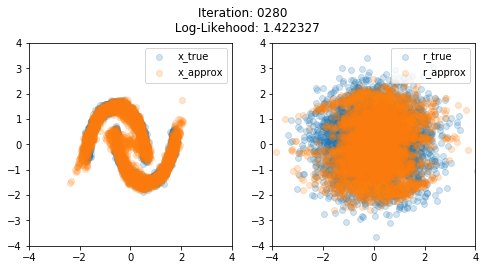

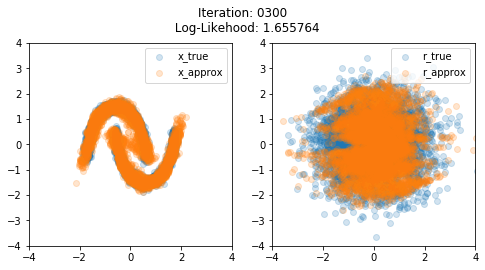

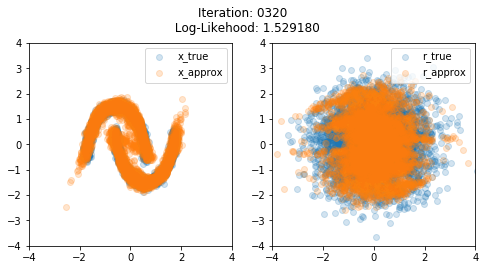

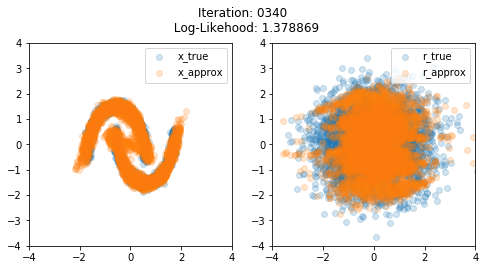

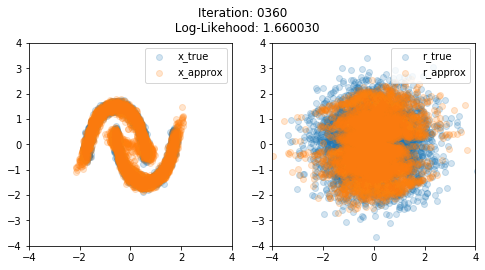

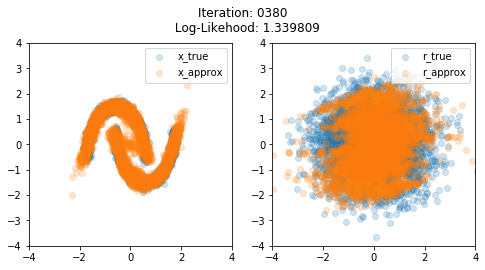

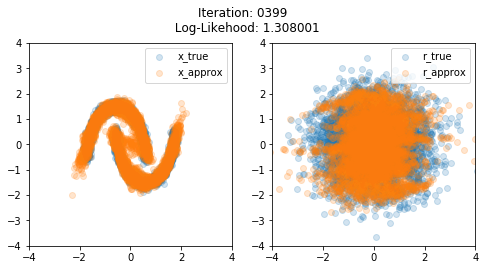

In [59]:
nvp.batch_norm_mode(True)
for i in range(maxIts):
    if i % 20 == 0:
        forward_vs_inv_plot(nvp,loss,i)
    XTs = tf.random.shuffle(XT)
    for j in range(0,N,batch_size):
        loss = KL_train_nvp(nvp,XTs[j:j+batch_size,:],opt)
forward_vs_inv_plot(nvp,loss,i)
nvp.batch_norm_mode(False)

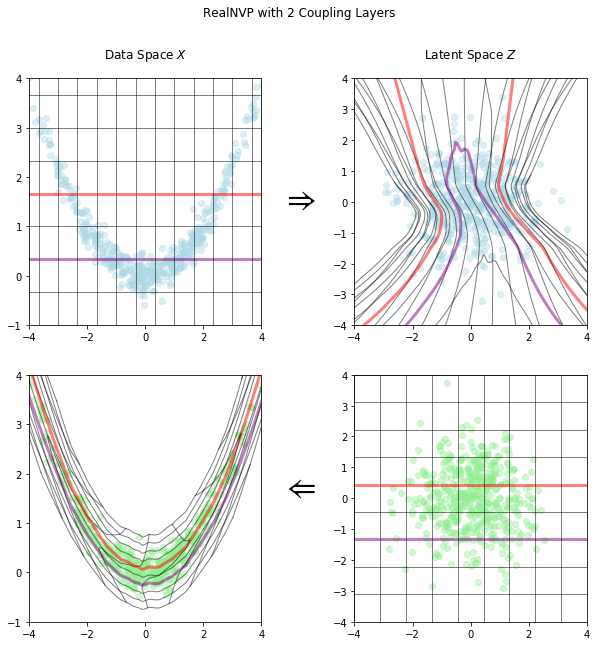

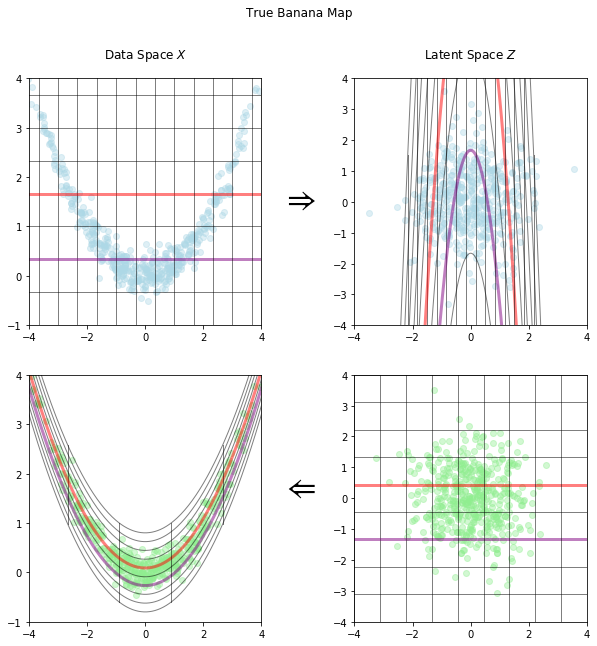

In [57]:
gridTransformPlot(nvp,nvp.inverse,
                  'RealNVP with 2 Coupling Layers','constraint_realNVP_changed_permute.png',
                  X_sample=bFlow.sample,
                  alpha = 0.5,
                  lw_grid=1.0,
                  N_lines1 = 16,
                  N_lines2=10,
                  constraint_index1 = [8,10],
                  constraint_index2 = [3,5],
                  xlims1=(-5.0,5.0),
                  ylims1=(-5.0,5.0),
                  xlims2=(-4.0,4.0),
                  ylims2=(-4.0,4.0))
gridTransformPlot(bMap.forward,bMap.inverse,
                  'True Banana Map','constraint_trueMap.png',
                  X_sample=bFlow.sample,
                  alpha = 0.5,
                  lw_grid=1.0,
                  N_lines1 = 16,
                  N_lines2=10,
                  constraint_index1 = [8,10],
                  constraint_index2 = [3,5],
                  xlims1=(-5.0,5.0),
                  ylims1=(-5.0,5.0),
                  xlims2=(-4.0,4.0),
                  ylims2=(-4.0,4.0))

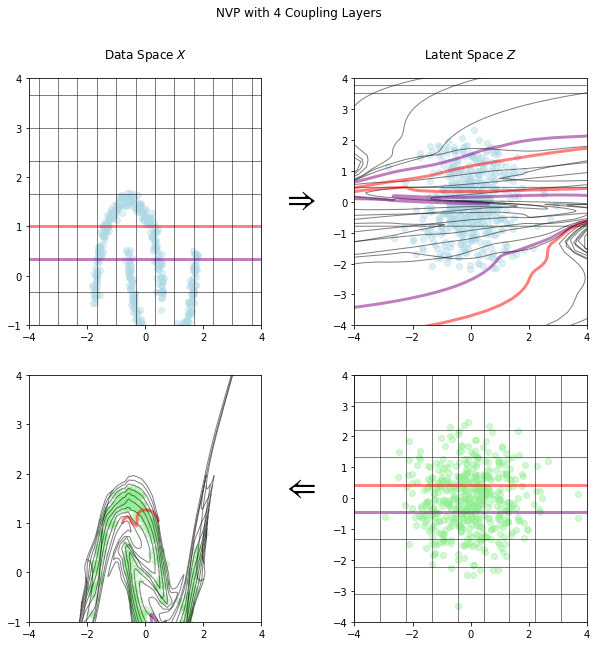

In [61]:
gridTransformPlot(nvp,nvp.inverse,
                  'NVP with 4 Coupling Layers',
                  'doubleMoon_changed_permute.png',
                 X_sample=moon_sample,
                 alpha = 0.5,
                  lw_grid=1.0,
                  N_lines1 = 16,
                  N_lines2=10,
                  constraint_index1 = [8,9],
                  constraint_index2 = [4,5],
                  xlims1=(-5.0,5.0),
                  ylims1=(-5.0,5.0),
                  xlims2=(-4.0,4.0),
                  ylims2=(-4.0,4.0))